# Pipeline Baseline: YOLO → Pinhole → ResNet → 6D Pose
Questa versione minimale esegue la pipeline base per la stima della posa 6D su LineMOD, ispirata al notebook test5_baseline_pinhole_pipeline.ipynb.

**Nota:** Questa pipeline minimale esegue solo un batch di test e mostra la traduzione e la rotazione predette. Per valutazioni complete e metriche, vedere il notebook originale test5_baseline_pinhole_pipeline.ipynb.

## 1. Import essenziali e setup minimal

In [1]:
# Import essenziali e setup minimal
import sys
from pathlib import Path
import torch
import os
import pandas as pd

sys.path.insert(0, str(Path.cwd().parent))
from config import Config
from models.pose_estimator_baseline import PoseEstimatorBaseline
from models.yolo_detector import YOLODetector
from utils.pinhole import compute_translation_pinhole
from dataset.linemod_pose import create_pose_dataloaders
from utils.validation import load_validation_results, calc_add_accuracy_per_class, calc_pinhole_error_per_class, run_yolo_baseline_pipeline
from utils.visualization import plot_add_per_class, plot_pinhole_error_per_class


## 2. Carica modelli pre-addestrati (YOLO e PoseEstimatorBaseline)

In [2]:
train_loader, val_loader, test_loader = create_pose_dataloaders(
    dataset_root=Config.LINEMOD_ROOT,
    batch_size=Config.POSE_BATCH_SIZE,
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE,
    num_workers=Config.NUM_WORKERS_POSE
)

In [3]:
# Carica modelli pre-addestrati (YOLO e PoseEstimatorBaseline)
yolo_weights = Config.CHECKPOINT_DIR / 'yolo' / 'yolo_train10' / 'weights' / 'best.pt'
yolo_detector = YOLODetector(model_name=str(yolo_weights), num_classes=Config.NUM_CLASSES) if yolo_weights.exists() else None
POSE_MODEL_NAME = 'pose_rgb_baseline'
pose_ckpt = Config.CHECKPOINT_DIR / 'pose' / POSE_MODEL_NAME / 'weights' / 'best.pt'
model_baseline = PoseEstimatorBaseline(pretrained=True).to(Config.DEVICE)
if pose_ckpt.exists():
    model_baseline.load_state_dict(torch.load(pose_ckpt, map_location=Config.DEVICE))
model_baseline.eval()

✅ Loading custom weights from: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/yolo/yolo_train10/weights/best.pt
PoseEstimatorBaseline initialized (BASELINE MODEL)
   Backbone: resnet50 (weights=ResNet50_Weights.IMAGENET1K_V1, frozen=False)
   Feature dim: 2048
   Output: 4 values (quaternion only)
   Translation: Computed with Pinhole Camera Model (NOT learned)
   Dropout: 0.5


PoseEstimatorBaseline(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

## 3. Carica un batch di test e applica la pipeline minimale

In [ ]:
# ⚠️ NOTA: Questa cella usa GT bbox, non YOLO detection!
# Per testare la pipeline completa con YOLO, usa la cella 11 (run_yolo_baseline_pipeline)

# Carica un batch di test e applica la pipeline minimale CON GT BBOX
train_loader, val_loader, test_loader = create_pose_dataloaders(
    dataset_root=Config.LINEMOD_ROOT,
    batch_size=1,
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE,
    num_workers=Config.NUM_WORKERS_POSE
)
batch = next(iter(test_loader))

# ✅ Usa immagini già croppate dal dataset (GT crops)
image = batch['rgb_crop'].to(Config.DEVICE)
bbox = batch['bbox'][0].cpu().numpy()  # GT bbox in formato xywh
depth_path = batch['depth_path'][0]

# Carica parametri intrinseci della camera per la scena corrente
from utils.pinhole import load_camera_intrinsics
info_yml_path = Path(depth_path).parent.parent / 'info.yml'
camera_intrinsics = load_camera_intrinsics(info_yml_path)

# ✅ Pipeline minimale: GT crop → ResNet (rotation) → Pinhole (translation)
# (Questa NON usa YOLO, usa bbox GT)
rotation = model_baseline(image).cpu().detach().numpy()
translation = compute_translation_pinhole(bbox, depth_path, camera_intrinsics)

# Ricava la ground truth della traslazione (se disponibile)
gt_translation = None
if 'translation' in batch:
    gt_translation = batch['translation'][0].cpu().numpy()

# Visualizza l'immagine con GT e predizione a confronto
import matplotlib.pyplot as plt
import numpy as np

img_vis = image.cpu().numpy()[0].transpose(1, 2, 0)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_vis = img_vis * std + mean
img_vis = np.clip(img_vis, 0, 1)

gt_quat = batch['quaternion'][0].cpu().numpy() if 'quaternion' in batch else None
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(img_vis)
ax.axis('off')
title = "Pipeline Baseline (GT bbox, no YOLO)\n"
title += f"Pred trans: {np.round(translation,2)}\n"
if gt_translation is not None:
    title += f"GT trans: {np.round(gt_translation,2)}\n"
title += f"Pred quat: {np.round(rotation[0],2)}"
if gt_quat is not None:
    title += f"\nGT quat: {np.round(gt_quat,2)}"
ax.set_title(title, fontsize=10)
plt.show()

print("\n💡 Per testare la pipeline COMPLETA con YOLO detection, esegui la cella 11!")

## 4. Pipeline completa YOLO + ResNet + Pinhole

Valuta la pipeline baseline end-to-end con YOLO detection su immagini full-size.  
Puoi scegliere tra:
- **Debug veloce**: 10 immagini (cella 4.1)
- **Validazione completa**: tutto il test set (cella 4.2)

In [4]:
# 🐛 DEBUG VELOCE: Test pipeline YOLO su solo 10 immagini
train_loader, val_loader, test_loader = create_pose_dataloaders(
    dataset_root=Config.LINEMOD_ROOT,
    batch_size=Config.POSE_BATCH_SIZE,
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE,
    num_workers=Config.NUM_WORKERS_POSE
)

# ✅ Usa max_samples=10 per debug veloce
run_yolo_baseline_pipeline(
    yolo_detector, 
    model_baseline, 
    test_loader, 
    name=POSE_MODEL_NAME,
    max_samples=10  # 🔧 Solo 10 immagini per debug rapido
)

print("\n💡 Per la validazione completa su tutto il test set, esegui la cella successiva!")

✅ Usando modello pose_rgb_baseline (già caricato)!
Carico odelli 3D degli oggetti in memoria. 
Questi vengono usati per calcolare la metrica ADD.
✅ Loaded model 01: 5841 points
✅ Loaded model 02: 38325 points
✅ Loaded model 04: 18995 points
✅ Loaded model 05: 22831 points
✅ Loaded model 06: 15736 points
✅ Loaded model 08: 12655 points
✅ Loaded model 09: 7912 points
✅ Loaded model 10: 18473 points
✅ Loaded model 11: 7479 points
✅ Loaded model 12: 15972 points
✅ Loaded model 13: 18216 points
✅ Loaded model 14: 27435 points
✅ Loaded model 15: 16559 points


Validazione YOLO pipeline (baseline, max 10 samples):   0%|          | 0/210 [00:16<?, ?it/s]

📊 Campioni processati: 64
⚠️  Detection failures: 0
Concatenazione batch...
Calcolo metriche: ADD completa 6D pose (rotation predetta + translation pinhole)
✅ Metriche calcolate.
✅ Risultati di validazione salvati in /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_baseline/validation_result.csv
✅ Risultati salvati in /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_baseline/validation_result.csv

💡 Per la validazione completa su tutto il test set, esegui la cella successiva!


In [6]:
# 🚀 VALIDAZIONE COMPLETA: Esegui la pipeline baseline su TUTTO il test set
# ⚠️ Questa cella può richiedere diversi minuti. Per debug veloce usa la cella precedente (10 immagini)

train_loader, val_loader, test_loader = create_pose_dataloaders(
    dataset_root=Config.LINEMOD_ROOT,
    batch_size=Config.POSE_BATCH_SIZE,
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE,
    num_workers=Config.NUM_WORKERS_POSE
)

# Processa tutto il test set (nessun limite)
run_yolo_baseline_pipeline(yolo_detector, model_baseline, test_loader, name=POSE_MODEL_NAME)

✅ Usando modello pose_rgb_baseline (già caricato)!
Carico odelli 3D degli oggetti in memoria. 
Questi vengono usati per calcolare la metrica ADD.
✅ Loaded model 01: 5841 points
✅ Loaded model 02: 38325 points
✅ Loaded model 04: 18995 points
✅ Loaded model 05: 22831 points
✅ Loaded model 06: 15736 points
✅ Loaded model 08: 12655 points
✅ Loaded model 09: 7912 points
✅ Loaded model 10: 18473 points
✅ Loaded model 11: 7479 points
✅ Loaded model 12: 15972 points
✅ Loaded model 13: 18216 points
✅ Loaded model 14: 27435 points
✅ Loaded model 15: 16559 points


Validazione YOLO pipeline (baseline):  40%|███▉      | 83/210 [21:42<32:44, 15.47s/it]

⚠️  Warning: Failed to compute translation for /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/data/Linemod_preprocessed/data/08/depth/0239.png: Invalid bbox after clipping: [164, 140, 164, 153]


Validazione YOLO pipeline (baseline):  84%|████████▍ | 176/210 [46:30<08:39, 15.28s/it]

⚠️  Warning: Failed to compute translation for /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/data/Linemod_preprocessed/data/13/depth/1129.png: Invalid bbox after clipping: [178, 70, 178, 135]


Validazione YOLO pipeline (baseline): 100%|██████████| 210/210 [55:29<00:00, 15.86s/it]


📊 Campioni processati: 13388
⚠️  Detection failures: 19
Concatenazione batch...
Calcolo metriche: ADD completa 6D pose (rotation predetta + translation pinhole)
✅ Metriche calcolate.
✅ Risultati di validazione salvati in /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_baseline/validation_result.csv
✅ Risultati salvati in /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_baseline/validation_result.csv


## 5. Carica e mostra tabella delle metriche per classe (ADD rot-only, errore pinhole)

In [7]:
# Carica e mostra tabella delle metriche per classe (ADD full pose)
val_csv_path = os.path.join(Config.CHECKPOINT_DIR, 'pose', POSE_MODEL_NAME, 'validation_result.csv')
results_full_pose, _ = load_validation_results(val_csv_path)

data, global_add, global_acc = calc_add_accuracy_per_class(results_full_pose, Config.LINEMOD_OBJECTS)

df = pd.DataFrame(data)
display(df)
print(f"\nMedia globale ADD (full pose): {global_add:.2f}")
print(f"Accuracy globale (full pose) (%): {global_acc:.1f}")

,Classe,Media ADD (rot-only),Accuracy (%)
0,01 - ape,24.26,15.8
1,02 - benchvise,38.23,36.1
2,04 - camera,28.89,35.0
3,05 - can,37.90,29.2
4,06 - cat,31.75,24.3
5,08 - driller,34.47,47.1
6,09 - duck,28.01,15.8
7,10 - eggbox,6.97,100.0
8,11 - glue,7.89,98.0
9,12 - holepuncher,29.51,26.1



Media globale ADD (full pose): 30.61
Accuracy globale (full pose) (%): 40.7


## 6. Grafico a barre delle medie ADD per classe (rot-only)
Mostra le medie della metrica ADD per ciascuna classe oggetto, calcolate sulla rotazione predetta.

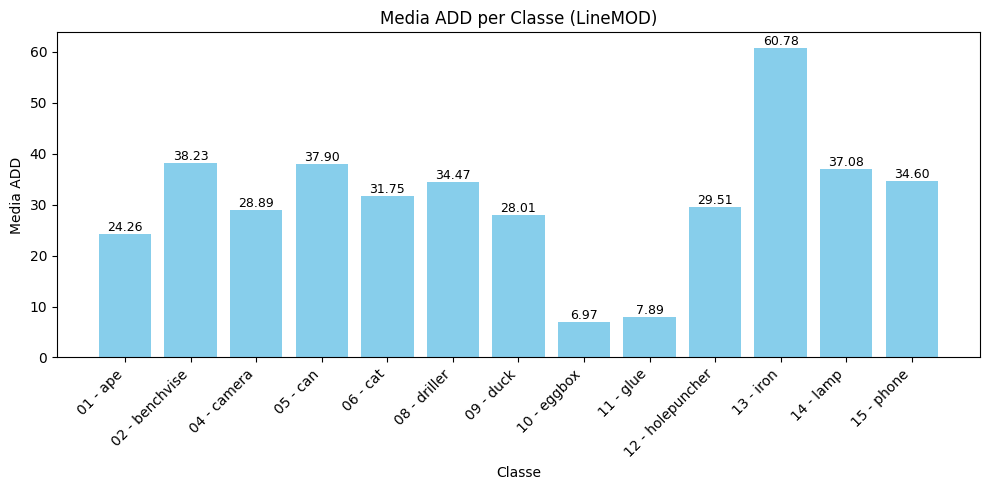

In [8]:
# Grafico a barre delle medie ADD per classe (full pose end-to-end)
results_full_pose = globals().get('results_full_pose', None)
if results_full_pose is None:
    print("⚠️  Devi prima calcolare la metrica ADD full pose su tutto il test set e salvare i risultati in 'results_full_pose'.")
else:
    plot_add_per_class(results_full_pose, Config.LINEMOD_OBJECTS)